# Endometriosis CD10 and ⍺-SMA
# Cluster analysis of image patches vectorized by EfficientNet B0

Following the approach of Ciga et al. (2021) as described in: Ciga, O., Xu, T., Nofech-Mozes, S. et al. Overcoming the limitations of patch-based learning to detect cancer in whole slide images. Sci Rep 11, 8894 (2021). https://doi.org/10.1038/s41598-021-88494-z

# Set up EfficientNet B0 with weights trained on ImageNet

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np   
import cv2
import h5py
import matplotlib.pyplot as plt

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.applications import EfficientNetB0

# Instantiate the EfficientNetB0 architecture
model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)



In [5]:
'''
# I actually wanted to show a figure of the network but it says it can't find graphviz 
# Print the model summary
model.summary()
'''

"\n# I actually wanted to show a figure of the network but it says it can't find graphviz \n# Print the model summary\nmodel.summary()\n"

# Load images from folders

In [6]:
import tifffile

(1091, 201, 201, 3)


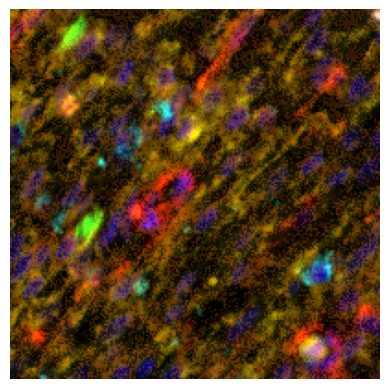

In [7]:
#For CD10

# Specify the folder path where the TIFF images are located
folder_path = '/Users/scott/Desktop/qupathlearning/CD10tiles_RGB'

# Get a list of all TIFF files in the folder
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Initialize an empty list to store the image data
x_raw_CD10 = []

# Loop through each TIFF file and load the image data
for tif_file in tif_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, tif_file)
    
    # Load the TIFF image using tifffile.imread()
    image_data = tifffile.imread(file_path)
    
    # Check if the image dimensions match 201x201 pixels
    if image_data.shape == (201, 201, 3):
        # Append the image data to the list
        x_raw_CD10.append(image_data)
        
# Convert the list to a numpy array for further processing
x_train_CD10 = np.array(x_raw_CD10[:1150]) # take only the first 1150 images 

# Print the shape of the array (number of images, height, width, channels)
print(x_train_CD10.shape)
image = x_train_CD10[1]  # Get the image data
plt.imshow(image)
plt.axis('off')  # Remove axis labels
plt.show()


(1150, 201, 201, 3)


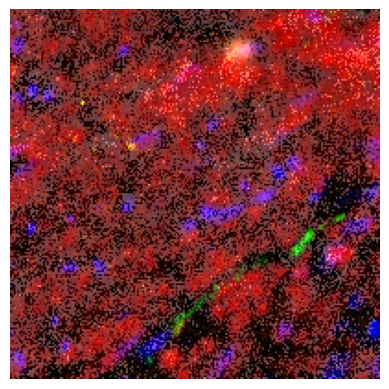

In [8]:
#For ⍺-SMA

# Specify the folder path where the TIFF images are located
folder_path = '/Users/scott/Desktop/qupathlearning/aSMAtiles_RGB'

# Get a list of all TIFF files in the folder
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

# Initialize an empty list to store the image data
x_raw_aSMA = []

# Loop through each TIFF file and load the image data
for tif_file in tif_files:
    # Construct the full file path
    file_path = os.path.join(folder_path, tif_file)
    
    # Load the TIFF image using tifffile.imread()
    image_data = tifffile.imread(file_path)
    
    # Check if the image dimensions match 201x201 pixels
    if image_data.shape == (201, 201, 3):
        # Append the image data to the list
        x_raw_aSMA.append(image_data)
        
# Convert the list to a numpy array for further processing
x_train_aSMA = np.array(x_raw_aSMA[:1150]) # take only the first 1150 images 

# Print the shape of the array (number of images, height, width, channels)
print(x_train_aSMA.shape)
image = x_train_aSMA[1]  # Get the image data
plt.imshow(image)
plt.axis('off')  # Remove axis labels
plt.show()


(2241, 201, 201, 3)


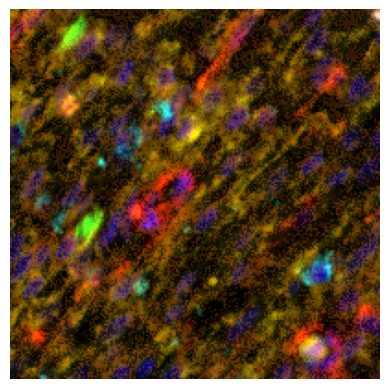

In [9]:
# Assuming you already have the arrays x_train_aSMA and x_train_CD10

# Merge the arrays along the first axis
x_train_merged = np.concatenate((x_train_aSMA, x_train_CD10), axis=0)

# Print the shape of the merged array
print(x_train_merged.shape)
image = x_train_merged[1151]  # images from 1151 upwards belong to the CD10 set 
plt.imshow(image)
plt.axis('off')  # Remove axis labels
plt.show()

# Get features from second to last layer (by ChatGPT)

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [11]:
# Preprocess by adjusting the images to the expected size from 96x96 --> 224x224
# Get the number of images
num_images = x_train_merged.shape[0]

# Create an empty array for resized images
resized_images = np.empty((num_images, 224, 224, 3), dtype=np.uint8)

# Resize each image to 224x224
for i in range(num_images):
    image = x_train_merged[i]
    resized_image = cv2.resize(image, (224, 224))
    resized_images[i] = resized_image


In [12]:
# Here I don't know wether this is necessary?

'''
The preprocessing logic has been included in the efficientnet model implementation. 
Users are no longer required to call this method to normalize the input data. 
This method does nothing and only kept as a placeholder to align 
the API surface between old and new version of model.
'''

# Preprocess the images in x_train to match the input shape of the EfficientNet-B0 model:
x_train_preprocessed = tf.keras.applications.efficientnet.preprocess_input(resized_images)

In [13]:
# Obtain the features by applying 2D average pooling to the output of the pre-activation layer:
features = model(x_train_preprocessed)# it works if you write model() instead of model.predict
features_pooled = np.mean(features, axis=(1, 2))  # Apply 2D average pooling


In [14]:
# Save the features to a CSV file:
df = pd.DataFrame(features_pooled)
df.to_csv('/Users/scott/Desktop/cluster_test/features.csv', index=False)

# Yields 1280 features like in Ciga et al. (2021)

# Cluster analysis using Mini Batch K-means clustering algorithm ChatGPT

In [15]:
df = pd.read_csv('/Users/scott/Desktop/cluster_test/features.csv')
features = df.values

In [16]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

n_clusters = 2  # Number of clusters
batch_size = len(df)  # Batch size for Mini-Batch K-means
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size)
kmeans.fit(features)

/Users/scott/ana/anaconda3/envs/condaenv4_tf_clustering/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


MiniBatchKMeans(batch_size=2241, n_clusters=2)

# Clustering following PCA

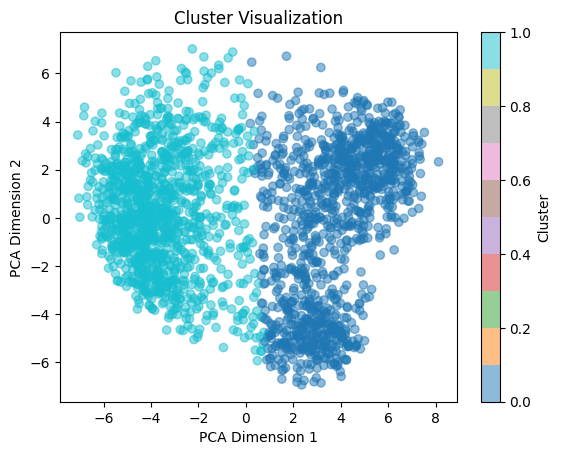

   Cluster  Count
0        0   1095
1        1   1146


In [17]:
# Show a plot of the clusters

labels = kmeans.labels_

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster')
plt.show()

# Show points per cluster
cluster_counts = pd.Series(labels).value_counts().sort_index()
cluster_table = pd.DataFrame({'Cluster': cluster_counts.index, 'Count': cluster_counts.values})
print(cluster_table)

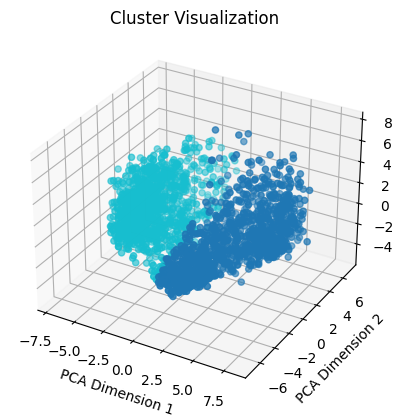

In [18]:
# Show as a 3D plot 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
features_3d = pca.fit_transform(features)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=labels, cmap='tab10')
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('PCA Dimension 3')
ax.set_title('Cluster Visualization')
plt.show()


# Showing the origin per point 

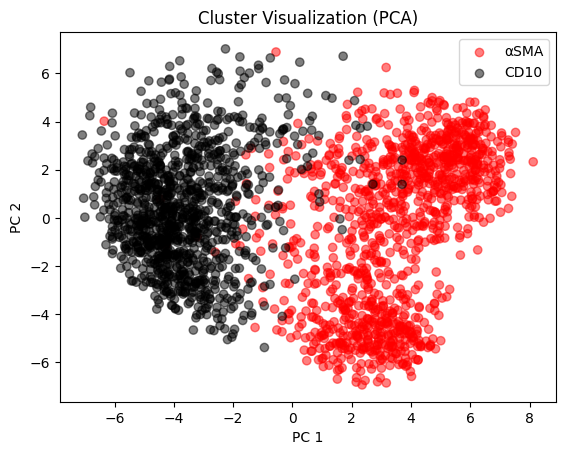

In [20]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

cluster_labels = kmeans.labels_

# Create an array to store the colors for each data point
colors = ['red' if i < 1151 else 'black' for i in range(len(cluster_labels))]

# Plot the reduced features with color-coded clusters
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.5)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Cluster Visualization (PCA)')


# Create custom legend entries for 'aSMA' and 'CD10'
red_patch = plt.scatter([], [], c='red', alpha=0.5, label='⍺SMA')
black_patch = plt.scatter([], [], c='black', alpha=0.5, label='CD10')

# Add both legend entries to the legend
plt.legend(handles=[red_patch, black_patch])


plt.show()

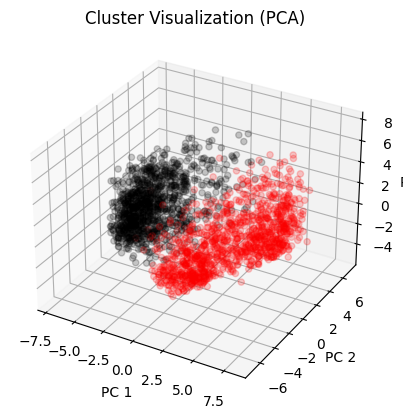

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

# Create an array to store the colors for each data point
colors = ['red' if i < 1151 else 'black' for i in range(len(cluster_labels))]

# Create a 3D figure and axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the reduced features with color-coded clusters in 3D
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.2)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_title('Cluster Visualization (PCA)')

plt.show()


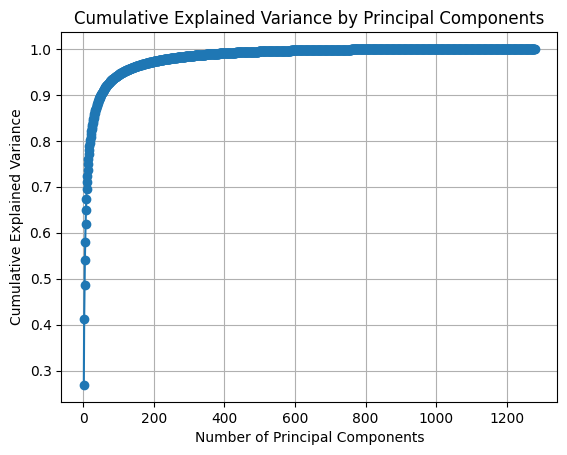

In [22]:
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
pca.fit(features)

# Calculate the cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

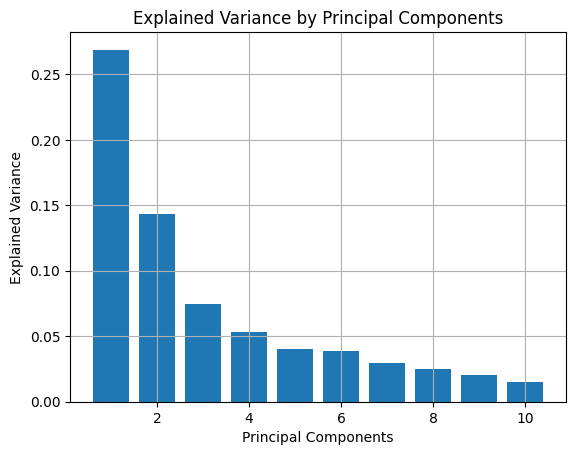

In [23]:
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA()
pca.fit(features)

# Calculate the explained variance for each principal component
explained_variance_ratio = pca.explained_variance_ratio_[:10]

# Plot the explained variance as bars
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

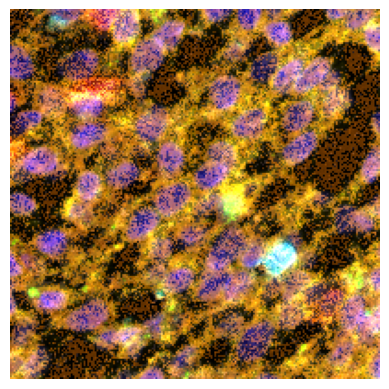

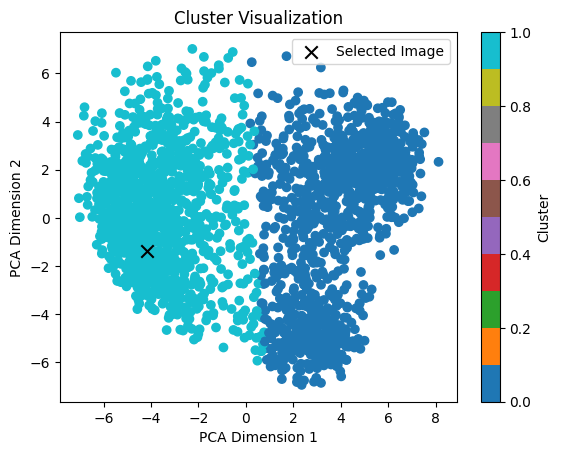

In [24]:
# Show the image of cluster 5 that is closest to the centre of that cluster 

from scipy.spatial.distance import cdist

cluster_id = 1  # Cluster ID of interest

# Retrieve indices of samples belonging to the specified cluster
cluster_indices = np.where(labels == cluster_id)[0]

# Calculate the centroid of the cluster
centroid = np.mean(features[cluster_indices], axis=0)

# Calculate the distances between the centroid and all samples in the cluster
distances = cdist(centroid.reshape(1, -1), features[cluster_indices], metric='euclidean')

# Find the index of the sample closest to the centroid
closest_index = cluster_indices[np.argmin(distances)]

# Retrieve and display the image
image = x_train_merged[closest_index]
plt.imshow(image)
plt.axis('off')
plt.show()

# Plot the points with different colors representing different clusters

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(label='Cluster')
plt.scatter(features_2d[closest_index, 0], features_2d[closest_index, 1], color='black', marker='x', s=80, label='Selected Image')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()



In [ ]:
# Show 3 images that are closest to the selected image 